In [1]:
# explor low rank structure of PINN
%load_ext autoreload
%autoreload 2


from minlora import add_lora, apply_to_lora, disable_lora, enable_lora, get_lora_params, merge_lora, name_is_lora, remove_lora, load_multiple_lora, select_lora, get_lora_state_dict, add_lora_by_name

from matplotlib import pyplot as plt


In [2]:
from Options import *
from DensePoisson import *

from Trainer import *
from lossCollection import *
from Problems import *

In [23]:

exp_name = 'loraseed'
name = 'p1D1_s0'
model, opt = load_model(exp_name, name)
        


Using Fourier Features
net loaded from /home/ziruz16/adjointpinn/mlruns/794851306132481054/3692a202bf9e40899de0c4868b5c23b5/artifacts/net.pth


In [24]:
 for name, layer in model.named_modules():
    print(name, layer)

 DensePoisson(
  (fflayer): Linear(in_features=1, out_features=64, bias=True)
  (input_layer): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (fcD): Linear(in_features=1, out_features=64, bias=False)
)
fflayer Linear(in_features=1, out_features=64, bias=True)
input_layer Linear(in_features=64, out_features=64, bias=True)
hidden_layers ModuleList(
  (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
)
hidden_layers.0 Linear(in_features=64, out_features=64, bias=True)
hidden_layers.1 Linear(in_features=64, out_features=64, bias=True)
output_layer Linear(in_features=64, out_features=1, bias=True)
fcD Linear(in_features=1, out_features=64, bias=False)


In [57]:
mlflow.get_artifact_uri()

'file:///home/ziruz16/adjointpinn/mlruns/385015914602905553/b50213130e754b2c961c75098ea54ca3/artifacts'

In [25]:
# add_lora(model)
add_lora_by_name(model, ['input_layer','hidden_layers','output_layer'])


In [26]:
 for name, layer in model.named_modules():
    print(name, layer)

 DensePoisson(
  (fflayer): Linear(in_features=1, out_features=64, bias=True)
  (input_layer): ParametrizedLinear(
    in_features=64, out_features=64, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (hidden_layers): ModuleList(
    (0-1): 2 x ParametrizedLinear(
      in_features=64, out_features=64, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): LoRAParametrization()
        )
      )
    )
  )
  (output_layer): ParametrizedLinear(
    in_features=64, out_features=1, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (fcD): Linear(in_features=1, out_features=64, bias=False)
)
fflayer Linear(in_features=1, out_features=64, bias=True)
input_layer ParametrizedLinear(
  in_features=64, out_features=64, bias=True
  (parametrizations): ModuleDict(
    (weight): 

In [27]:
pde_opts = {
        'problem': 'PoissonProblem',
        'p': 2,
        'exact_D': 1.0,
        'init_D': 1.0,
    }
pde = create_pde_problem(**pde_opts)
optobj = Options()


dataset = setup_dataset(pde, 'forward', {'use_noise':False}, optobj.opts['dataset_opts'])

No noise added


In [28]:
loss_pde_opts = {'weights':{'res':optobj.opts['weights']['res'],'data':optobj.opts['weights']['data']}}
lc = {}
lc['forward'] = lossCollection(model, pde, dataset, list(get_lora_params(model)), optim.Adam, loss_pde_opts)

In [29]:
dataset['x_res_train'].requires_grad = True

In [31]:
estop = EarlyStopping(**optobj.opts['train_opts'])
optsobj = Options()
optobj.opts['train_opts']['tolerance'] = 1e-3

trainer = Trainer(optsobj.opts, model, pde, dataset, lc)
trainer.setup_mlflow()


Current tracking uri: file:///home/ziruz16/adjointpinn/mlruns


In [32]:
trainer.train()

Epoch 0, res: 820, data: 0.99, total: 821, D: 1
Epoch 20, res: 817, data: 0.979, total: 818, D: 1
Epoch 40, res: 808, data: 0.943, total: 809, D: 1
Epoch 60, res: 791, data: 0.874, total: 792, D: 1
Epoch 80, res: 764, data: 0.774, total: 765, D: 1
Epoch 100, res: 729, data: 0.67, total: 730, D: 1
Epoch 120, res: 684, data: 0.601, total: 685, D: 1
Epoch 140, res: 622, data: 0.547, total: 623, D: 1
Epoch 160, res: 546, data: 0.478, total: 546, D: 1
Epoch 180, res: 467, data: 0.397, total: 468, D: 1
Epoch 200, res: 390, data: 0.329, total: 390, D: 1
Epoch 220, res: 298, data: 0.287, total: 298, D: 1
Epoch 240, res: 203, data: 0.245, total: 204, D: 1
Epoch 260, res: 130, data: 0.207, total: 130, D: 1
Epoch 280, res: 80.8, data: 0.182, total: 81, D: 1
Epoch 300, res: 50.5, data: 0.153, total: 50.6, D: 1
Epoch 320, res: 32.5, data: 0.125, total: 32.6, D: 1
Epoch 340, res: 21.9, data: 0.0952, total: 22, D: 1
Epoch 360, res: 15.3, data: 0.07, total: 15.3, D: 1
Epoch 380, res: 10.9, data: 0.050

In [33]:
lora_state_dict = get_lora_state_dict(model)

In [34]:
for k in lora_state_dict.keys():
    print(k, lora_state_dict[k].shape)

input_layer.parametrizations.weight.0.lora_A torch.Size([4, 64])
input_layer.parametrizations.weight.0.lora_B torch.Size([64, 4])
hidden_layers.0.parametrizations.weight.0.lora_A torch.Size([4, 64])
hidden_layers.0.parametrizations.weight.0.lora_B torch.Size([64, 4])
hidden_layers.1.parametrizations.weight.0.lora_A torch.Size([4, 64])
hidden_layers.1.parametrizations.weight.0.lora_B torch.Size([64, 4])
output_layer.parametrizations.weight.0.lora_A torch.Size([4, 64])
output_layer.parametrizations.weight.0.lora_B torch.Size([1, 4])


In [35]:
merge_lora(model)

In [53]:
remove_lora(model)
add_lora_by_name(model, ['input_layer','hidden_layers','output_layer'])
_ = model.load_state_dict(lora_state_dict, strict=False)
merge_lora(model)

In [51]:
from PlotHelper import *

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'final D: 1.000'}>)

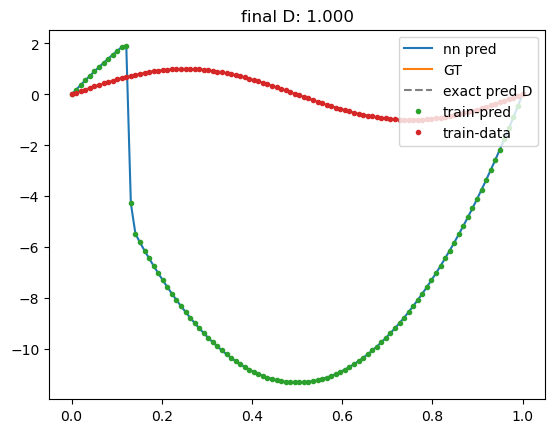

In [54]:

ph = PlotHelper(pde, dataset, yessave=False, exact_D=pde.exact_D)
ph.plot_prediction(model)

In [ ]:
model2, opt = load_model(exp_name, name)
model2.freeze_layers_except(1)

In [ ]:
lc = {}
lc['forward'] = lossCollection(model2, pde, dataset, model2.param_net, optim.Adam, loss_pde_opts)



estop = EarlyStopping(**optobj.opts['train_opts'])
trainer2 = Trainer(optsobj.opts, model2, pde, dataset, lc)
trainer2.train()

In [ ]:

ph.plot_prediction(model2)